## Import Libraries

In [ ]:
!pip install filetype

In [ ]:
import os
import pathlib
import filetype
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
filename="/content/drive/MyDrive/MyThesis/dataset.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")

!ls /content/

done
dataset2  drive  __MACOSX  sample_data


In [ ]:
def load_filenames(dataset_dir):
    '''Load the filenames and their corresponding label indices from a specified dataset directory.'''

    filenames = []
    label_idxs = []

    i = 0
    for lab in os.listdir(dataset_dir):
        current_dir = os.path.join(dataset_dir, lab)
        for img in os.listdir(current_dir):
            filenames.append(os.path.join(current_dir, img))
            label_idxs.append(i)
        i += 1

    print('Loading filenames completed.')

    return filenames, label_idxs


In [ ]:
# Remove unnecessary .DS_Store files. Generated by MacOS
os.remove('/content/dataset2/.DS_Store')
os.remove('/content/dataset2/covid/.DS_Store')

In [ ]:
dataset_dir = '/content/dataset2'
class_names = ['covid', 'normal', 'pneumonia']
X, Y = load_filenames(dataset_dir)

Loading filenames completed.


In [ ]:
# Identify files with unrecognized formats
corrupted_images = np.array([True if filetype.guess(filename)==None else False for filename in X])
# Remove such files from the list
X_clean = list(np.array(X)[~corrupted_images])
# Check the formats of the images in the dataset
image_format = [filetype.guess(filename).extension for filename in X_clean]

print('Recognized Formats: ', np.unique(image_format))
print('\nN. of Images (before): ', len(X))
print('N. of Images (after) : ', len(X_clean))
print('N. of Corrupted Images: ', np.sum(corrupted_images))
print('\nCorrupted Images:')
for img in list(np.array(X)[corrupted_images]):
    print(img)

Recognized Formats:  ['bmp' 'jpg' 'png']

N. of Images (before):  4575
N. of Images (after) :  4575
N. of Corrupted Images:  0

Corrupted Images:


## Preprocessing

To ensure uniform input dimensions for the model, all images were resized to 224x224 pixels. Normalization was applied by dividing pixel values by 255. Additionally, to mitigate the impact of frequently embedded textual information in chest X-ray images, the top and bottom 8% of each image was cropped prior to training, as in Wang et al.

In [ ]:
def preprocess(image):
    '''Preprocess an image applying normalization, cropping and resizing'''

    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [224, 224])
    image = tf.image.crop_to_bounding_box(image, offset_height=int(224*0.1), offset_width=0, target_height=int(224*0.8), target_width=int(224))
    image = tf.image.resize(image, [224, 224])
    return image

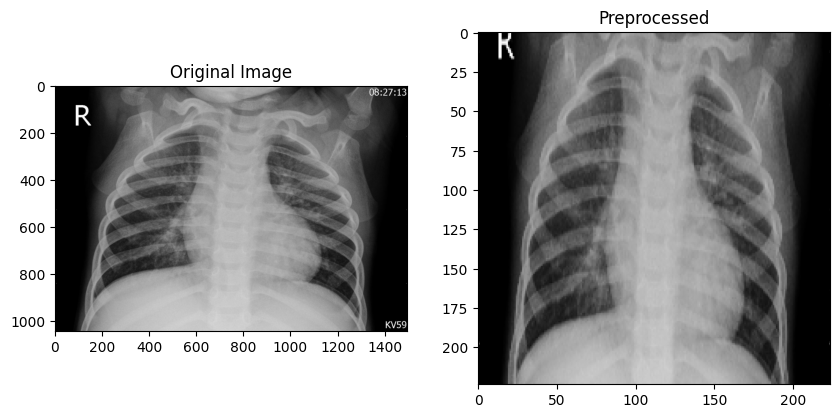

In [ ]:
img = tf.io.read_file(X[1018])
img = tf.io.decode_image(img, channels=3)
preprocessed_img = preprocess(img)

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[1].imshow(preprocessed_img)
ax[1].set_title('Preprocessed');

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='constant'),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant'),
    tf.keras.layers.RandomRotation(factor=0.1, fill_mode='constant'),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1)
])

augmented_img = data_augmentation(preprocessed_img)

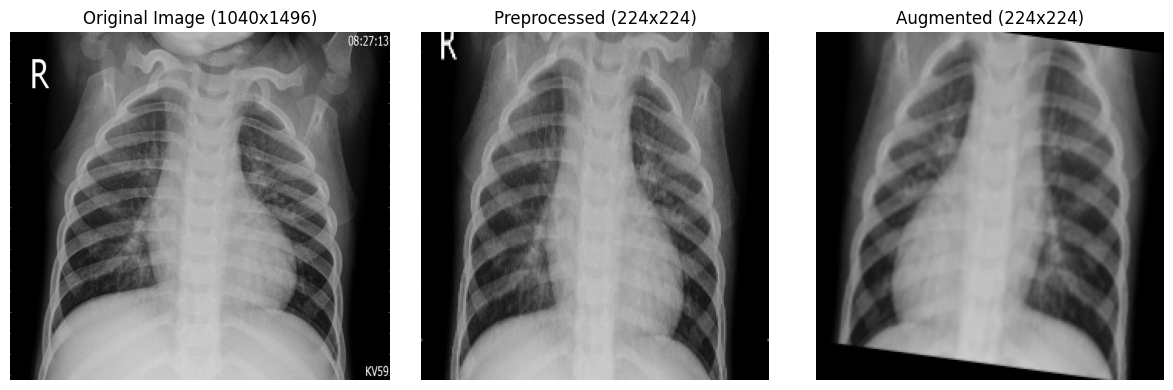

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(img, aspect='auto')
ax[0].set_title(f'Original Image ({img.shape[0]}x{img.shape[1]})')
ax[0].axis('off')

ax[1].imshow(preprocessed_img)
ax[1].set_title(f'Preprocessed ({preprocessed_img.shape[0]}x{preprocessed_img.shape[1]})')
ax[1].axis('off')

ax[2].imshow(augmented_img)
ax[2].set_title(f'Augmented ({augmented_img.shape[0]}x{augmented_img.shape[1]})')
ax[2].axis('off')

plt.tight_layout()
plt.savefig('/content/preprocessing_and_augmentation.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Dataset creation



In [ ]:
def get_label(file_path):
    '''Parse the label from the file path'''

    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    '''
    Decode the image and convert it into a Tensor using tf.io.decode_image.
    It supports multiple image formats including is a BMP, GIF, JPEG, and PNG.
    '''

    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3)
    # Ensure the image has shape [height, width, channels]
    img = tf.ensure_shape(img, [None, None, 3])

    return img

def load_image_with_label(file_path):
    '''Load an image and its label given the file path'''

    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def create_dataset(file_names, batch_size, shuffle, augment=True, cache_file=None):
    '''
    Constructs a TensorFlow Dataset object configured for image processing.

    This function prepares a dataset by loading images, applying preprocessing,
    and optionally augmenting, shuffling, batching, and prefetching the data.
    The dataset can be cached to speed up operations.
    '''

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(file_names)

    # Map the load_image function
    dataset = dataset.map(load_image_with_label, num_parallel_calls=tf.data.AUTOTUNE)

    # Map the preprocess function
    dataset = dataset.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Map the augment_image function
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(100)

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    print("Dataset correctly created.")

    return dataset

Create the dataset using the functions defined above.

In [ ]:
batch_size = 16
ds = create_dataset(X_clean,
                    batch_size=batch_size,
                    shuffle=True,
                    augment=True
                    )

Dataset correctly created.


Plot some samples.

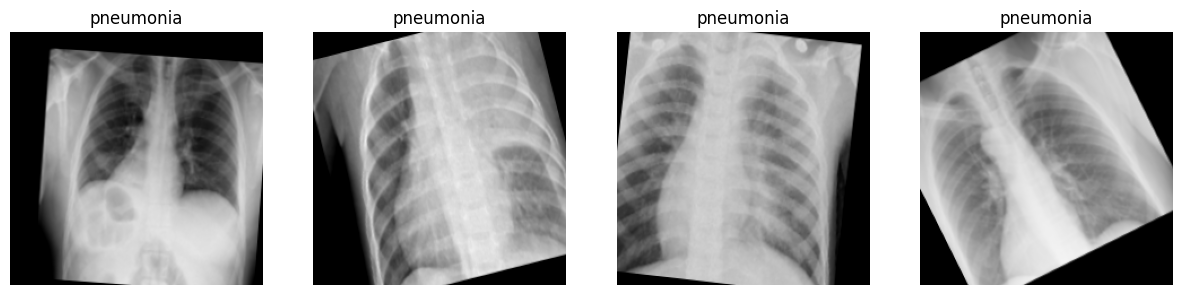

In [ ]:
image_batch, label_batch = next(iter(ds))

plt.figure(figsize=(15, 10))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [ ]:
def conv_block(X, filters=32, kernel_size=(3,3), strides=(2,2), alpha=1.0, id="1"):
    '''Standard Convolution'''

    # First Conv
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=kernel_size, strides=strides, padding='same', name=f'conv_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_{id}_relu')(X)

    return X

def depthwise_conv_block(X, filters, strides=(1,1), alpha=1.0, id=None):
    '''Depthwise Separable Convolution'''

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    return X

In [ ]:
X = tf.random.uniform(shape=(1, 112, 112, 32), dtype=tf.float32)
depthwise_conv_block(X, filters=64, strides=(2,2)).shape

TensorShape([1, 56, 56, 64])

In [ ]:
def mobilenet_v1(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV1 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha=alpha, id="1")
    X = depthwise_conv_block(X, 64, (1,1), alpha, id=1)

    X = depthwise_conv_block(X, 128, (2,2), alpha, id=2)
    X = depthwise_conv_block(X, 128, (1,1), alpha, id=3)

    X = depthwise_conv_block(X, 256, (2,2), alpha, id=4)
    X = depthwise_conv_block(X, 256, (1,1), alpha, id=5)

    X = depthwise_conv_block(X, 512, (2,2), alpha, id=6)
    for i in range(5):
        X = depthwise_conv_block(X, 512, (1,1), alpha, id=7+i)

    X = depthwise_conv_block(X, 1024, (2,2), alpha, id=12)
    X = depthwise_conv_block(X, 1024, (1,1), alpha, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

In [ ]:
model = mobilenet_v1(input_shape=(224,224,3), include_top=True)

print(f"Output Shape: {model.output_shape}")
print(f"Total params: {model.count_params()}")
model.summary()

Output Shape: (None, 3)
Total params: 3242883


Model: "mobilenet_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (Activation)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (Activation)     │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (Activation)     │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (Activation)     │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (Activation)     │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (Activation)     │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_relu (Activation)     │ (None, 56, 56, 128)    │             

 Total params: 3,242,883 (12.37 MB)

 Trainable params: 3,220,995 (12.29 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
def bottleneck(input, expansion, stride, alpha, filters, block_id):
    """Bottleneck residual block."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion*k), kernel_size=(1,1), strides=(1,1), padding='same', name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), padding='same', name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X


In [ ]:
X = tf.random.uniform(shape=(1, 112, 112, 24), dtype=tf.float32)
bottleneck(X, 1, (1,1), 1.0, 24, '1').shape

TensorShape([1, 112, 112, 24])

In [ ]:
def mobilenet_v2(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV2 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = bottleneck(input=X, expansion=1, stride=1, alpha=alpha, filters=16, block_id="1")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=24, block_id="2")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=24, block_id="3")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=32, block_id="4")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="5")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="6")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=64, block_id="7")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="8")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="9")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="10")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="11")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="12")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="13")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=160, block_id="14")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="15")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="16")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=320, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

In [ ]:
model = mobilenet_v2(input_shape=(224,224,3), include_top=True)

print(f"Output Shape: {model.output_shape}")
print(f"Total params: {model.count_params()}")
model.summary()

Output Shape: (None, 3)
Total params: 2280067


Model: "mobilenet_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (Activation)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_1 (Conv2D)            │ (None, 112, 112, 32)   │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_1_bn                  │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_1_relu (Activation)   │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (Activation)     │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_1 (Conv2D)           │ (None, 112, 112, 16)   │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_1_bn                 │ (None, 112, 112, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_2 (Conv2D)            │ (None, 112, 112, 96)   │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_2_bn                  │ (None, 112, 112, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_2_relu (Activation)   │ (None, 112, 112, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (Activation)     │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_2 (Conv2D)           │ (None, 56, 56, 24)     │         2,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_2_bn                 │ (None, 56, 56, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_3 (Conv2D)            │ (None, 56, 56, 144)    │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expansion_3_bn                  │ (None, 56, 56, 144)    │           57

 Total params: 2,280,067 (8.70 MB)

 Trainable params: 2,245,891 (8.57 MB)

 Non-trainable params: 34,176 (133.50 KB)

In [ ]:
def se_block(input, reduction_ratio, id):
    '''Squeeze-and-Exitation Block.'''

    c = input.shape[-1]

    # Squeeze
    X = tf.keras.layers.GlobalAveragePooling2D(name=f"se_{id}_avg_pool")(input)
    X = tf.keras.layers.Reshape((1, 1, c))(X)

    # Excitation
    X = tf.keras.layers.Dense(units=(c // reduction_ratio), activation="relu", use_bias=False, name=f"fc1_{id}")(X)
    X = tf.keras.layers.Dense(units=c, activation="sigmoid", use_bias=False, name=f"fc2_{id}")(X)

    return tf.keras.layers.Multiply(name=f"gate_{id}")([input, X])

In [ ]:
X = tf.random.uniform((1, 112, 112, 32))
se_block(X, 16, '1').shape

TensorShape([1, 112, 112, 32])

In [ ]:
def se_depthwise_conv_block(input, filters, strides=(1,1), alpha=1.0, reduction_ratio=16, se=False, id=None):
    '''Depthwise Separable Convolution with Squeeze-and-Exitation'''

    k = input.shape[-1]

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(input)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    # SE Block
    if se:
        X = se_block(X, reduction_ratio, id=id)

    return X

In [ ]:
def se_mobilenet_v1(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV1 enhanced with Squeeze-and-Exitation blocks'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha, id=1)
    X = se_depthwise_conv_block(X, 64, (1,1), alpha, reduction_ratio, se=False, id=1)

    X = se_depthwise_conv_block(X, 128, (2,2), alpha, reduction_ratio, se=False, id=2)
    X = se_depthwise_conv_block(X, 128, (1,1), alpha, reduction_ratio, se=False, id=3)

    X = se_depthwise_conv_block(X, 256, (2,2), alpha, reduction_ratio, se=False, id=4)
    X = se_depthwise_conv_block(X, 256, (1,1), alpha, reduction_ratio, se=False, id=5)

    X = se_depthwise_conv_block(X, 512, (2,2), alpha, reduction_ratio, se=True, id=6)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=7)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=8)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=9)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=10)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=11)

    X = se_depthwise_conv_block(X, 1024, (2,2), alpha, reduction_ratio, se=True, id=12)
    X = se_depthwise_conv_block(X, 1024, (1,1), alpha, reduction_ratio, se=True, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

    #X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

In [ ]:
input_shape = (224,224,3)
print("MobileNetV1 params:"+' '*11, mobilenet_v1(input_shape).count_params())
for r in [32, 16, 8, 4]:
    print(f"SE-MobileNetV1 (r={r:02}) params: ", se_mobilenet_v1(input_shape, r).count_params())

MobileNetV1 params:            3242883
SE-MobileNetV1 (r=32) params:  3472259
SE-MobileNetV1 (r=16) params:  3701635
SE-MobileNetV1 (r=08) params:  4160387
SE-MobileNetV1 (r=04) params:  5077891


In [ ]:
def se_bottleneck(input, expansion, stride, alpha, filters, reduction_ratio, se=False, block_id=None):
    """Bottleneck residual block with Squeeze-and-Exitation."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion * k), kernel_size=(1,1), strides=(1,1), name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Squeeze-and-Excitation
    if se:
        X = se_block(X, reduction_ratio, id=block_id)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    # Shortcut connection
    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X

In [ ]:
def se_mobilenet_v2(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV2 with SE Blocks.'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = bottleneck(input=X, expansion=1, stride=1, alpha=alpha, filters=16, block_id="1")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=24, block_id="2")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=24, block_id="3")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=32, block_id="4")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="5")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="6")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=64, block_id="7")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="8")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="9")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="10")

    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="11")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="12")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, block_id="13")

    X = se_bottleneck(input=X, expansion=6, stride=(2,2), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="14")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="15")
    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, block_id="16")

    X = se_bottleneck(input=X, expansion=6, stride=(1,1), alpha=alpha, filters=320, reduction_ratio=reduction_ratio, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

In [ ]:
input_shape = (224,224,3)
print("MobileNetV2 params:"+' '*11, mobilenet_v2(input_shape).count_params())
for r in [32, 16, 8, 4]:
    print(f"SE-MobileNetV2 (r={r:02}) params: ", se_mobilenet_v2(input_shape, r).count_params())

MobileNetV2 params:            2280067
SE-MobileNetV2 (r=32) params:  2280067
SE-MobileNetV2 (r=16) params:  2280067
SE-MobileNetV2 (r=08) params:  2280067
SE-MobileNetV2 (r=04) params:  2280067


In [ ]:
dataset_dir = '/content/dataset2'

# Load images
X, Y = load_filenames(dataset_dir)

Loading filenames completed.


In [ ]:
# Train-Validation-Test Split: 0.7, 0.1, 0.2
X_train_val, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.1, random_state=42)

# Dataset creation
batch_size = 16
train_dataset = create_dataset(X_train,
                               batch_size=batch_size,
                               shuffle=True,
                               augment=True
                               )
val_dataset = create_dataset(X_val,
                             batch_size=batch_size,
                             shuffle=False,
                             augment=False
                             )
test_dataset = create_dataset(X_test,
                              batch_size=batch_size,
                              shuffle=False,
                              augment=False
                              )

train_steps = int(np.ceil(len(X_train) / batch_size))
val_steps = int(np.ceil(len(X_val) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

Dataset correctly created.
Dataset correctly created.
Dataset correctly created.


In [ ]:
import tensorflow as tf

def conv_block(X, filters=32, kernel_size=(3,3), strides=(2,2), alpha=1.0, id="1"):
    '''Standard Convolution'''

    # First Conv
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=kernel_size, strides=strides, padding='same', name=f'conv_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_{id}_relu')(X)

    return X

def depthwise_conv_block(X, filters, strides=(1,1), alpha=1.0, id=None):
    '''Depthwise Separable Convolution'''

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    return X


def mobilenet_v1(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV1 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha=alpha, id="1")
    X = depthwise_conv_block(X, 64, (1,1), alpha, id=1)

    X = depthwise_conv_block(X, 128, (2,2), alpha, id=2)
    X = depthwise_conv_block(X, 128, (1,1), alpha, id=3)

    X = depthwise_conv_block(X, 256, (2,2), alpha, id=4)
    X = depthwise_conv_block(X, 256, (1,1), alpha, id=5)

    X = depthwise_conv_block(X, 512, (2,2), alpha, id=6)
    for i in range(5):
        X = depthwise_conv_block(X, 512, (1,1), alpha, id=7+i)

    X = depthwise_conv_block(X, 1024, (2,2), alpha, id=12)
    X = depthwise_conv_block(X, 1024, (1,1), alpha, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='mobilenet_v1')

In [ ]:
import tensorflow as tf

def conv_block(X, filters=32, kernel_size=(3,3), strides=(2,2), alpha=1.0, id="1"):
    '''Standard Convolution'''

    # First Conv
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=kernel_size, strides=strides, padding='same', name=f'conv_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_{id}_relu')(X)

def bottleneck(input, expansion, stride, alpha, filters, block_id):
    """Bottleneck residual block."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion*k), kernel_size=(1,1), strides=(1,1), padding='same', name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), padding='same', name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X


def mobilenet_v2(input_shape, include_top=True, alpha=1.0, classes=3):
    '''Implementation of MobileNetV2 architecture'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = bottleneck(input=X, expansion=1, stride=1, alpha=alpha, filters=16, block_id="1")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=24, block_id="2")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=24, block_id="3")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=32, block_id="4")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="5")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=32, block_id="6")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=64, block_id="7")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="8")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="9")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=64, block_id="10")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="11")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="12")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=96, block_id="13")

    X = bottleneck(input=X, expansion=6, stride=2, alpha=alpha, filters=160, block_id="14")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="15")
    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=160, block_id="16")

    X = bottleneck(input=X, expansion=6, stride=1, alpha=alpha, filters=320, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='mobilenet_v2')

In [ ]:
import tensorflow as tf
# from .mobilenet_v1 import conv_block, depthwise_conv_block
# from .mobilenet_v2 import bottleneck

def conv_block(X, filters=32, kernel_size=(3,3), strides=(2,2), alpha=1.0, id="1"):
    '''Standard Convolution'''

    # First Conv
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=kernel_size, strides=strides, padding='same', name=f'conv_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_{id}_relu')(X)

    return X

def depthwise_conv_block(X, filters, strides=(1,1), alpha=1.0, id=None):
    '''Depthwise Separable Convolution'''

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    return X

def bottleneck(input, expansion, stride, alpha, filters, block_id):
    """Bottleneck residual block."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion*k), kernel_size=(1,1), strides=(1,1), padding='same', name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), padding='same', name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X

def se_block(input, reduction_ratio, id):
    '''Squeeze-and-Exitation Block.'''

    c = input.shape[-1]

    # Squeeze
    X = tf.keras.layers.GlobalAveragePooling2D(name=f"se_{id}_avg_pool")(input)
    X = tf.keras.layers.Reshape((1, 1, c))(X)

    # Excitation
    X = tf.keras.layers.Dense(units=(c // reduction_ratio), activation="relu", use_bias=False, name=f"fc1_{id}")(X)
    X = tf.keras.layers.Dense(units=c, activation="sigmoid", use_bias=False, name=f"fc2_{id}")(X)

    return tf.keras.layers.Multiply(name=f"gate_{id}")([input, X])

### SE-MobileNetV1

def se_depthwise_conv_block(input, filters, strides=(1,1), alpha=1.0, reduction_ratio=16, se=False, id=None):
    '''Depthwise Separable Convolution with Squeeze-and-Exitation'''

    k = input.shape[-1]

    # Depth-Wise Convolution
    X = tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=strides, padding='same', name=f'conv_dw_{id}')(input)
    X = tf.keras.layers.BatchNormalization(name=f'conv_dw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_dw_{id}_relu')(X)

    # Point-Wise Convolution
    X = tf.keras.layers.Conv2D(filters=int(filters*alpha), kernel_size=(1,1), name=f'conv_pw_{id}')(X)
    X = tf.keras.layers.BatchNormalization(name=f'conv_pw_{id}_bn')(X)
    X = tf.keras.layers.Activation('relu', name=f'conv_pw_{id}_relu')(X)

    # SE Block
    if se:
        X = se_block(X, reduction_ratio, id=id)

    return X

def se_mobilenet_v1(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV1 enhanced with SE blocks'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, 32, (3,3), (2,2), alpha, id=1)
    X = se_depthwise_conv_block(X, 64, (1,1), alpha, reduction_ratio, se=False, id=1)

    X = se_depthwise_conv_block(X, 128, (2,2), alpha, reduction_ratio, se=False, id=2)
    X = se_depthwise_conv_block(X, 128, (1,1), alpha, reduction_ratio, se=False, id=3)

    X = se_depthwise_conv_block(X, 256, (2,2), alpha, reduction_ratio, se=False, id=4)
    X = se_depthwise_conv_block(X, 256, (1,1), alpha, reduction_ratio, se=False, id=5)

    X = se_depthwise_conv_block(X, 512, (2,2), alpha, reduction_ratio, se=True, id=6)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=7)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=8)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=9)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=10)
    X = se_depthwise_conv_block(X, 512, (1,1), alpha, reduction_ratio, se=True, id=11)

    X = se_depthwise_conv_block(X, 1024, (2,2), alpha, reduction_ratio, se=True, id=12)
    X = se_depthwise_conv_block(X, 1024, (1,1), alpha, reduction_ratio, se=True, id=13)
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

    #X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)

    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v1')

### SE-MobileNetV2

def se_bottleneck(input, expansion, stride, alpha, filters, reduction_ratio, se=False, block_id=None):
    """Bottleneck residual block with Squeeze-and-Exitation."""

    # Number of input channels
    k = input.shape[-1]

    # Expansion
    X = tf.keras.layers.Conv2D(filters=(expansion * k), kernel_size=(1,1), strides=(1,1), name=f"expansion_{block_id}")(input)
    X = tf.keras.layers.BatchNormalization(name=f"expansion_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"expansion_{block_id}_relu")(X)

    # Depthwise convolution
    X = tf.keras.layers.DepthwiseConv2D((3,3), strides=stride, padding='same', name=f"conv_dw_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"conv_dw_{block_id}_bn")(X)
    X = tf.keras.layers.Activation('relu', name=f"conv_dw_{block_id}_relu")(X)

    # Squeeze-and-Excitation
    if se:
        X = se_block(X, reduction_ratio, id=block_id)

    # Projection
    X = tf.keras.layers.Conv2D(filters=int(filters * alpha), kernel_size=(1,1), strides=(1,1), name=f"projection_{block_id}")(X)
    X = tf.keras.layers.BatchNormalization(name=f"projection_{block_id}_bn")(X)

    # Shortcut connection
    if k == X.shape[-1] and stride == (1,1):
        X = tf.keras.layers.Add(name=f"shortcut_{block_id}")([X, input])

    return X

def se_mobilenet_v2(input_shape, reduction_ratio=16, include_top=True, alpha=1.0, classes=3):
    '''MobileNetV2 with SE Blocks.'''

    X_input = tf.keras.layers.Input(input_shape, name='input_layer')

    X = conv_block(X_input, filters=32, kernel_size=(3,3), strides=(2,2), alpha=alpha, id="1")

    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=16, reduction_ratio=reduction_ratio, se=False, block_id="1")

    X = se_bottleneck(X, expansion=6, stride=(2,2), alpha=alpha, filters=24, reduction_ratio=reduction_ratio, se=False, block_id="2")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=24, reduction_ratio=reduction_ratio, se=False, block_id="3")

    X = se_bottleneck(X, expansion=6, stride=(2,2), alpha=alpha, filters=32, reduction_ratio=reduction_ratio, se=False, block_id="4")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=32, reduction_ratio=reduction_ratio, se=False, block_id="5")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=32, reduction_ratio=reduction_ratio, se=False, block_id="6")

    X = se_bottleneck(X, expansion=6, stride=(2,2), alpha=alpha, filters=64, reduction_ratio=reduction_ratio, se=False, block_id="7")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=64, reduction_ratio=reduction_ratio, se=False, block_id="8")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=64, reduction_ratio=reduction_ratio, se=False, block_id="9")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=64, reduction_ratio=reduction_ratio, se=False, block_id="10")

    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, se=True, block_id="11")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, se=True, block_id="12")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=96, reduction_ratio=reduction_ratio, se=True, block_id="13")

    X = se_bottleneck(X, expansion=6, stride=(2,2), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, se=True, block_id="14")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, se=True, block_id="15")
    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=160, reduction_ratio=reduction_ratio, se=True, block_id="16")

    X = se_bottleneck(X, expansion=6, stride=(1,1), alpha=alpha, filters=320, reduction_ratio=reduction_ratio, se=True, block_id="17")

    X = conv_block(X, filters=1280, kernel_size=(1,1), strides=(1,1), alpha=alpha, id="2")
    X = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(X)

    if include_top == False:
        return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

    X = tf.keras.layers.Dense(units=classes, activation=None, name='dense')(X)
    return tf.keras.models.Model(X_input, X, name='se_mobilenet_v2')

In [ ]:
model_name = 'mobilenet_v2'

learning_rate = 0.01
#learning_rate = 0.001
#learning_rate = 0.0001

In [ ]:
input_shape = (224, 224, 3)

#model initialization
model = mobilenet_v2(input_shape)

# Compilare il modello
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Definire il callback per ridurre il learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=5,
                                min_lr=1e-4, # rule of thumb -> initial_lr * 1%
                                verbose=1)

# Definire il callback per salvare il miglior modello
checkpoint = ModelCheckpoint(filepath=f'/content/models/weights/{learning_rate}_{model_name}.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                verbose=1)

# Definire il callback per l'early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, start_from_epoch=20, restore_best_weights=True, verbose=1)

# Addestrare il modello
history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=50,
                        batch_size=batch_size,
                        steps_per_epoch=train_steps,
                        validation_steps=val_steps,
                        callbacks=[reduce_lr, checkpoint])


Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5014 - loss: 1.5180
Epoch 1: val_loss improved from inf to 1.22515, saving model to /content/models/weights/0.01_mobilenet_v2.keras
206/206 ━━━━━━━━━━━━━━━━━━━━ 158s 464ms/step - accuracy: 0.5018 - loss: 1.5158 - val_accuracy: 0.3179 - val_loss: 1.2252 - learning_rate: 0.0100
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6668 - loss: 0.7827
Epoch 2: val_loss did not improve from 1.22515
206/206 ━━━━━━━━━━━━━━━━━━━━ 139s 678ms/step - accuracy: 0.6669 - loss: 0.7827 - val_accuracy: 0.3179 - val_loss: 1.7008 - learning_rate: 0.0100
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.7272 - loss: 0.6779
Epoch 3: val_loss did not improve from 1.22515
206/206 ━━━━━━━━━━━━━━━━━━━━ 88s 430ms/step - accuracy: 0.7272 - loss: 0.6779 - val_accuracy: 0.5054 - val_loss: 3.2990 - learning_rate: 0.0100
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7398 - loss: 0.6664
Epoch 4:

In [ ]:
# Output path
experiment_name = f'{model_name}_{learning_rate}'
output_path = f'/content/drive/MyDrive/MyThesis/result/{experiment_name}'

final_model_path = f'{output_path}_weight.keras'
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

✅ Final model saved to: /content/drive/MyDrive/MyThesis/result/mobilenet_v2_0.01_weight.keras


In [ ]:
# Save training history to drive
import json

# Convert history object to a dictionary
history_dict = {}
for key in history.history:
    history_dict[key] = list(map(float, history.history[key]))

# Save history as JSON file
# with open('/training_history.json', 'w') as f:
#     json.dump(history_dict, f)
with open(f'{output_path}_training_history.json', 'w') as f:
    json.dump(history_dict, f)

print("✅ History saved to drive successfully!")

✅ History saved to drive successfully!


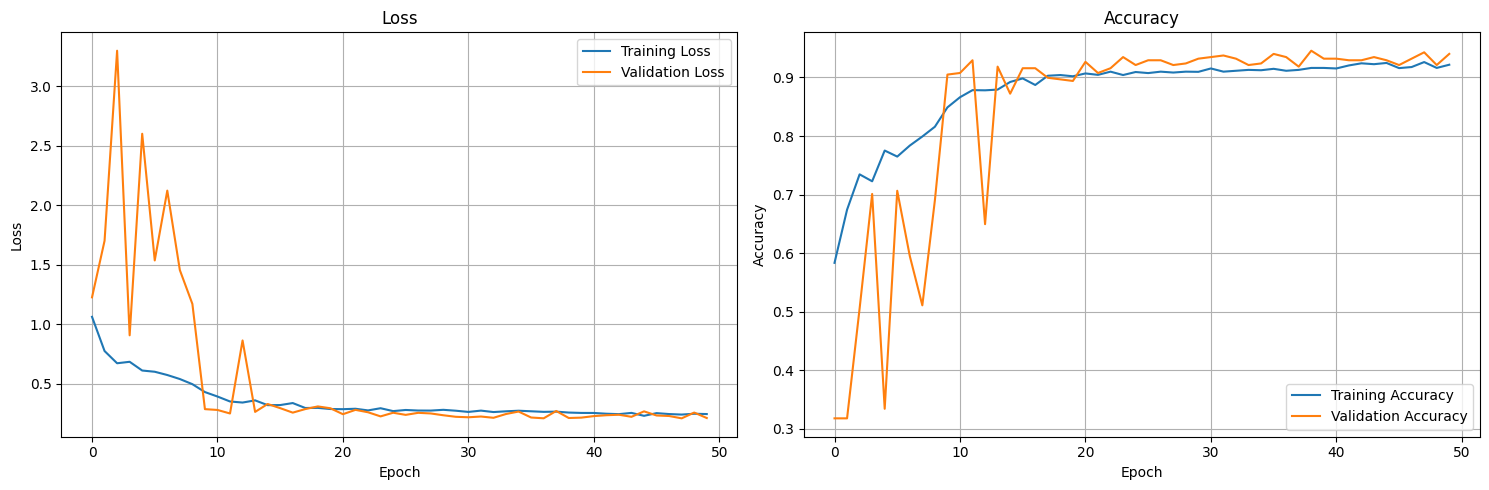

In [ ]:
# Load history from file
with open(f'{output_path}_training_history.json', 'r') as f:
    loaded_history = json.load(f)

# Plot training & validation loss and accuracy
def plot_history(history_dict):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history_dict['loss'], label='Training Loss')
    ax1.plot(history_dict['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history_dict['accuracy'], label='Training Accuracy')
    ax2.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{output_path}_training_history.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

# Display the plots
plot_history(loaded_history)

In [ ]:
# Load the trained model and calculate all evaluation metrics
import numpy as np
import tensorflow as tf
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                           confusion_matrix, roc_auc_score, matthews_corrcoef)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load the trained model
print("Loading trained model...")
model = tf.keras.models.load_model(final_model_path)
print("Model loaded successfully!")

# Make predictions on test set
print("Making predictions on test set...")
y_pred_probs = model.predict(test_dataset, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels from test dataset
print("Extracting true labels...")
y_true = []
for batch in test_dataset.take(test_steps):
    _, labels = batch
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# Ensure we have the right number of predictions
if len(y_pred) > len(y_true):
    y_pred = y_pred[:len(y_true)]
    y_pred_probs = y_pred_probs[:len(y_true)]

print(f"Number of test samples: {len(y_true)}")
print(f"Number of predictions: {len(y_pred)}")
print(f"Class distribution: {np.bincount(y_true)}")

# Calculate metrics
print("Calculating metrics...")

# 1. Precision (macro and weighted averages for multi-class)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)

# 2. Recall/Sensitivity
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

# 3. F1-Score
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# 4. Accuracy
accuracy = accuracy_score(y_true, y_pred)

# 5. Specificity (calculated from confusion matrix)
cm = confusion_matrix(y_true, y_pred)
specificity_per_class = []
for i in range(len(class_names)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificity_per_class.append(specificity)
specificity_macro = np.mean(specificity_per_class)

# 6. AUC-ROC (for multi-class)
try:
    # Binarize labels for multi-class ROC-AUC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    auc_macro = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_pred_probs, average='weighted', multi_class='ovr')
except Exception as e:
    print(f"Warning: Could not calculate AUC-ROC: {e}")
    auc_macro = 0.0
    auc_weighted = 0.0

# 7. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_true, y_pred)

print("All metrics calculated successfully!")
print("\n" + "="*50)
print("EVALUATION METRICS SUMMARY")
print("="*50)
print(f"Precision (Macro):     {precision_macro:.4f}")
print(f"Precision (Weighted):  {precision_weighted:.4f}")
print(f"Recall (Macro):        {recall_macro:.4f}")
print(f"Recall (Weighted):     {recall_weighted:.4f}")
print(f"F1-Score (Macro):      {f1_macro:.4f}")
print(f"F1-Score (Weighted):   {f1_weighted:.4f}")
print(f"Accuracy:              {accuracy:.4f}")
print(f"Specificity (Macro):   {specificity_macro:.4f}")
print(f"AUC-ROC (Macro):       {auc_macro:.4f}")
print(f"AUC-ROC (Weighted):    {auc_weighted:.4f}")
print(f"MCC:                   {mcc:.4f}")
print("="*50)

Loading trained model...
Model loaded successfully!
Making predictions on test set...
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step
Extracting true labels...
Number of test samples: 928
Number of predictions: 928
Class distribution: [296 302 330]
Calculating metrics...
All metrics calculated successfully!

EVALUATION METRICS SUMMARY
Precision (Macro):     0.9279
Precision (Weighted):  0.9288
Recall (Macro):        0.9285
Recall (Weighted):     0.9278
F1-Score (Macro):      0.9278
F1-Score (Weighted):   0.9279
Accuracy:              0.9278
Specificity (Macro):   0.9641
AUC-ROC (Macro):       0.9787
AUC-ROC (Weighted):    0.9785
MCC:                   0.8920


In [ ]:
# Calculate detailed classification report
from sklearn.metrics import classification_report

print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT")
print("="*50)

# Generate the classification report dictionary
class_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)

# Print the text version for immediate review (optional)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

print("Detailed classification report calculated successfully!")



DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

       covid       0.93      0.94      0.94       296
      normal       0.90      0.93      0.91       302
   pneumonia       0.96      0.91      0.93       330

    accuracy                           0.93       928
   macro avg       0.93      0.93      0.93       928
weighted avg       0.93      0.93      0.93       928

Detailed classification report calculated successfully!


In [ ]:
# Create and save EVALUATION METRICS SUMMARY and Detailed Classification Report as CSV files

# 1. EVALUATION METRICS SUMMARY as CSV
print("="*60)
print("📊 CREATING EVALUATION METRICS SUMMARY CSV")
print("="*60)

evaluation_summary = {
    'Metric': [
        'Precision (Macro)',
        'Precision (Weighted)',
        'Recall (Macro)',
        'Recall (Weighted)',
        'F1-Score (Macro)',
        'F1-Score (Weighted)',
        'Accuracy',
        'Specificity (Macro)',
        'AUC-ROC (Macro)',
        'AUC-ROC (Weighted)',
        'Matthews Correlation Coefficient (MCC)'
    ],
    'Value': [
        f"{precision_macro:.4f}",
        f"{precision_weighted:.4f}",
        f"{recall_macro:.4f}",
        f"{recall_weighted:.4f}",
        f"{f1_macro:.4f}",
        f"{f1_weighted:.4f}",
        f"{accuracy:.4f}",
        f"{specificity_macro:.4f}",
        f"{auc_macro:.4f}",
        f"{auc_weighted:.4f}",
        f"{mcc:.4f}"
    ]
    # ,
    # 'Description': [
    #     'Average precision across all classes (unweighted)',
    #     'Average precision weighted by class support',
    #     'Average recall/sensitivity across all classes (unweighted)',
    #     'Average recall/sensitivity weighted by class support',
    #     'Average F1-score across all classes (unweighted)',
    #     'Average F1-score weighted by class support',
    #     'Overall classification accuracy',
    #     'Average specificity across all classes',
    #     'Average AUC-ROC across all classes (unweighted)',
    #     'Average AUC-ROC weighted by class support',
    #     'Matthews Correlation Coefficient (overall model quality)'
    # ]
}

df_summary = pd.DataFrame(evaluation_summary)

# Save evaluation summary as CSV
summary_csv_path = f'{output_path}_evaluation_metrics_summary.csv'
df_summary.to_csv(summary_csv_path, index=False)

print(f"✅ Evaluation Metrics Summary saved to: {summary_csv_path}")
print("\n📋 EVALUATION METRICS SUMMARY TABLE:")
print(df_summary.to_string(index=False))

# 2. DETAILED CLASSIFICATION REPORT as CSV
print("\n" + "="*60)
print("📊 CREATING DETAILED CLASSIFICATION REPORT CSV")
print("="*60)

# Create detailed per-class metrics
detailed_report_data = []

# Add per-class metrics
for i, class_name in enumerate(class_names):
    class_metrics = class_report[class_name]
    detailed_report_data.append({
        'Class': class_name.capitalize(),
        'Precision': f"{class_metrics['precision']:.4f}",
        'Recall': f"{class_metrics['recall']:.4f}",
        'F1-Score': f"{class_metrics['f1-score']:.4f}",
        'Support': int(class_metrics['support']),
        'Specificity': f"{specificity_per_class[i]:.4f}"
    })

# Add overall metrics
detailed_report_data.append({
    'Class': 'Macro Average',
    'Precision': f"{class_report['macro avg']['precision']:.4f}",
    'Recall': f"{class_report['macro avg']['recall']:.4f}",
    'F1-Score': f"{class_report['macro avg']['f1-score']:.4f}",
    'Support': int(class_report['macro avg']['support']),
    'Specificity': f"{specificity_macro:.4f}"
})

detailed_report_data.append({
    'Class': 'Weighted Average',
    'Precision': f"{class_report['weighted avg']['precision']:.4f}",
    'Recall': f"{class_report['weighted avg']['recall']:.4f}",
    'F1-Score': f"{class_report['weighted avg']['f1-score']:.4f}",
    'Support': int(class_report['weighted avg']['support']),
    'Specificity': f"{specificity_macro:.4f}"  # Using macro for consistency
})

df_detailed = pd.DataFrame(detailed_report_data)

# Save detailed report as CSV
detailed_csv_path = f'{output_path}_detailed_classification_report.csv'
df_detailed.to_csv(detailed_csv_path, index=False)

print(f"✅ Detailed Classification Report saved to: {detailed_csv_path}")
print("\n📋 DETAILED CLASSIFICATION REPORT TABLE:")
print(df_detailed.to_string(index=False))

# 3. CREATE A COMBINED SUMMARY FOR EASY REFERENCE
print("\n" + "="*60)
print("📊 COMBINED SUMMARY")
print("="*60)

combined_summary = f"""
SE-MobileNetV1 Performance Summary
================================
Model: SE-MobileNetV1 (Squeeze-and-Excitation MobileNetV1)
Dataset: COVID-19 Chest X-Ray Classification
Classes: {', '.join(class_names)}
Total Test Samples: {len(y_true)}

Class Distribution:
- COVID-19: {np.bincount(y_true)[0]} samples ({np.bincount(y_true)[0]/len(y_true)*100:.1f}%)
- Normal: {np.bincount(y_true)[1]} samples ({np.bincount(y_true)[1]/len(y_true)*100:.1f}%)
- Pneumonia: {np.bincount(y_true)[2]} samples ({np.bincount(y_true)[2]/len(y_true)*100:.1f}%)

Key Performance Metrics:
- Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)
- Macro F1-Score: {f1_macro:.4f}
- Weighted F1-Score: {f1_weighted:.4f}
- Matthews Correlation Coefficient: {mcc:.4f}
- AUC-ROC (Macro): {auc_macro:.4f}

Files Saved to Google Drive:
1. evaluation_metrics_summary.csv
2. detailed_classification_report.csv
3. classification_metrics_table.svg
4. confusion_matrix.svg
5. classification_report.txt
"""

print(combined_summary)

# Save combined summary as text file
combined_path = f'{output_path}_combined_performance_summary.txt'
with open(combined_path, 'w') as f:
    f.write(combined_summary)

print(f"✅ Combined summary saved to: {combined_path}")
print(f"\n🎉 All CSV files and summaries have been created and saved to your Google Drive!")
print(f"\n📁 CSV Files Created:")
print(f"   • {summary_csv_path}")
print(f"   • {detailed_csv_path}")
print(f"   • {combined_path}")


📊 CREATING EVALUATION METRICS SUMMARY CSV
✅ Evaluation Metrics Summary saved to: /content/drive/MyDrive/MyThesis/result/mobilenet_v2_0.01_evaluation_metrics_summary.csv

📋 EVALUATION METRICS SUMMARY TABLE:
                                Metric  Value
                     Precision (Macro) 0.9279
                  Precision (Weighted) 0.9288
                        Recall (Macro) 0.9285
                     Recall (Weighted) 0.9278
                      F1-Score (Macro) 0.9278
                   F1-Score (Weighted) 0.9279
                              Accuracy 0.9278
                   Specificity (Macro) 0.9641
                       AUC-ROC (Macro) 0.9787
                    AUC-ROC (Weighted) 0.9785
Matthews Correlation Coefficient (MCC) 0.8920

📊 CREATING DETAILED CLASSIFICATION REPORT CSV
✅ Detailed Classification Report saved to: /content/drive/MyDrive/MyThesis/result/mobilenet_v2_0.01_detailed_classification_report.csv

📋 DETAILED CLASSIFICATION REPORT TABLE:
           Class Pr

🎨 CREATING VISUALIZATION FIGURES


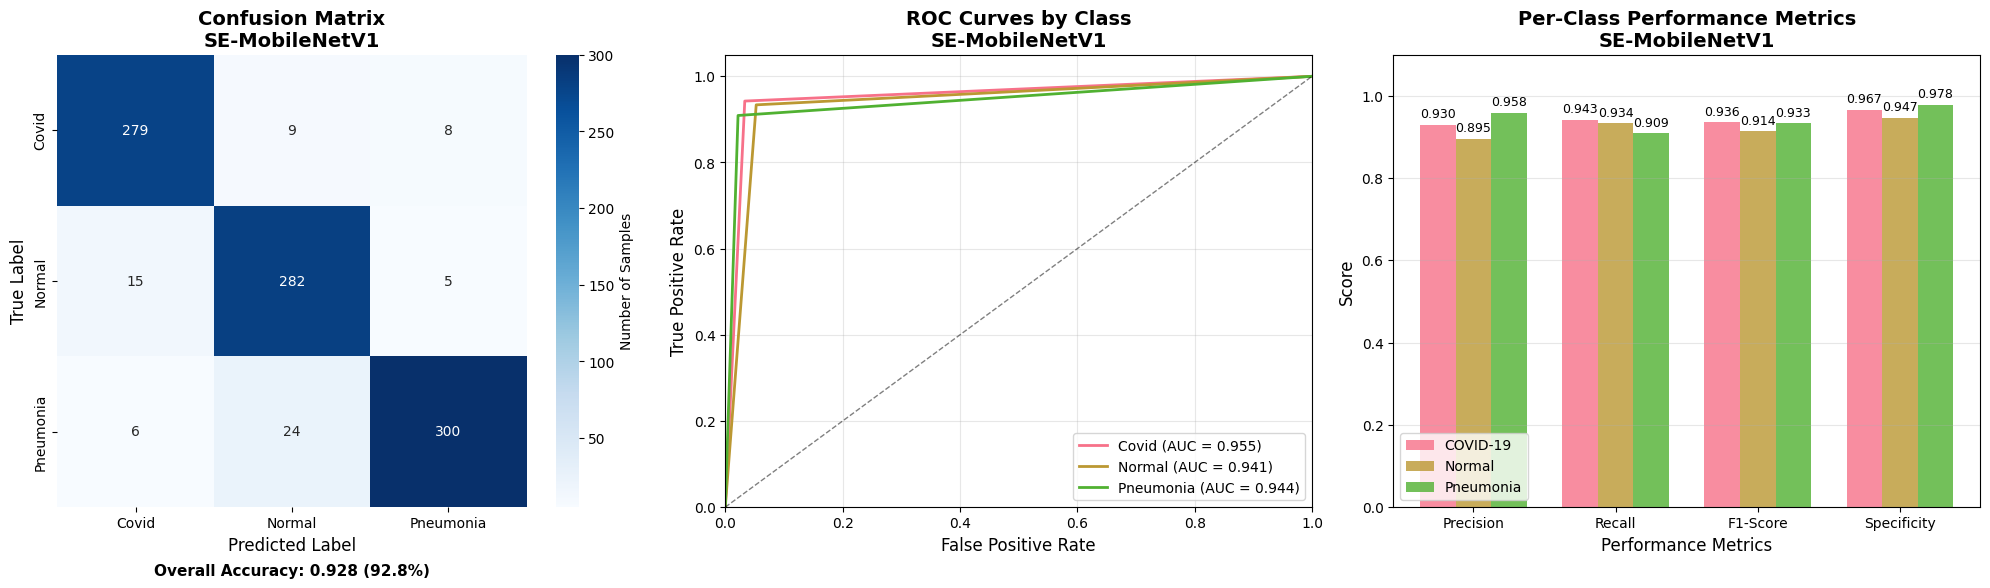

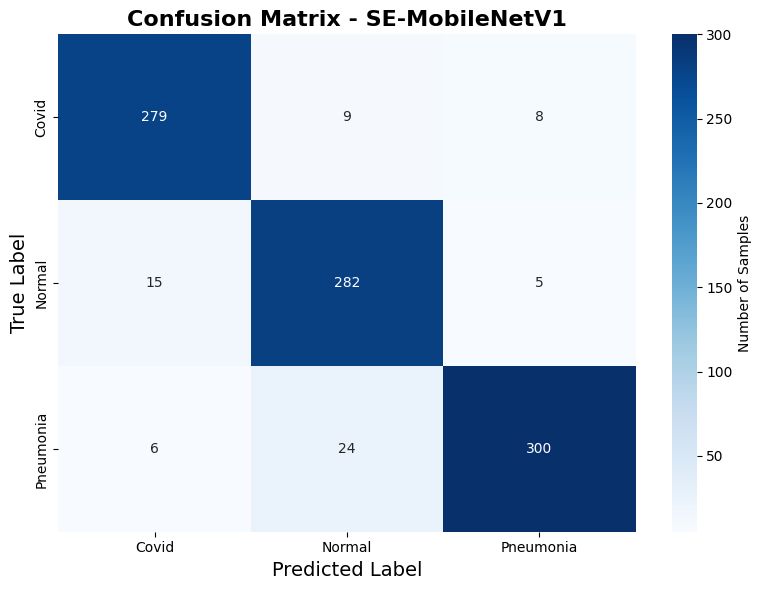

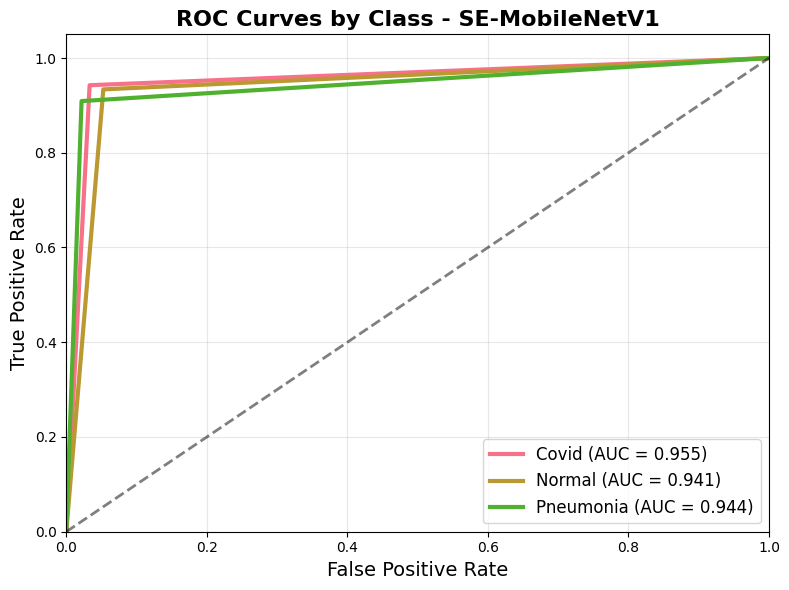

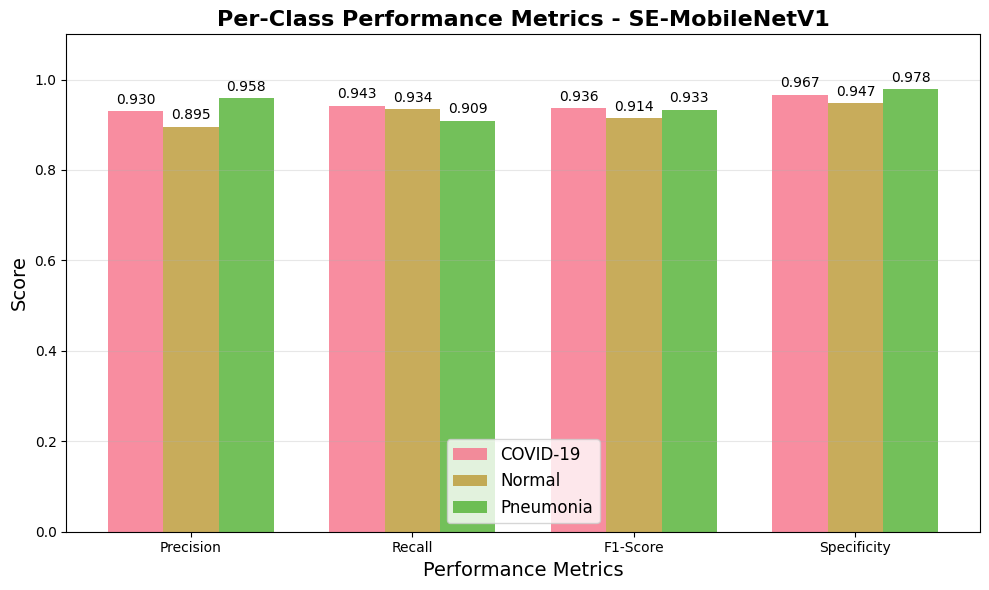

✅ ALL VISUALIZATIONS CREATED AND SAVED!

📊 Files saved to Google Drive:
   📁 Combined Figure:
      • /content/drive/MyDrive/MyThesis/result/mobilenet_v2_0.01_evaluation_visualizations.png
      • /content/drive/MyDrive/MyThesis/result/mobilenet_v2_0.01_evaluation_visualizations.svg

   📁 Individual Figures:
      • /content/drive/MyDrive/MyThesis/confusion_matrix_individual.png
      • /content/drive/MyDrive/MyThesis/confusion_matrix_individual.svg
      • /content/drive/MyDrive/MyThesis/roc_curves_individual.png
      • /content/drive/MyDrive/MyThesis/roc_curves_individual.svg
      • /content/drive/MyDrive/MyThesis/performance_metrics_individual.png
      • /content/drive/MyDrive/MyThesis/performance_metrics_individual.svg

🎯 Summary of Results:
   • Overall Accuracy: 0.928 (92.8%)
   • Macro F1-Score: 0.928
   • Matthews Correlation Coefficient: 0.892
   • Best Performing Class: Covid

🎉 Visualization creation completed successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

print("="*70)
print("🎨 CREATING VISUALIZATION FIGURES")
print("="*70)

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with 3 subplots
fig = plt.figure(figsize=(20, 6))

# ============================================================================
# 1. CONFUSION MATRIX
# ============================================================================
ax1 = plt.subplot(1, 3, 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.capitalize() for name in class_names],
            yticklabels=[name.capitalize() for name in class_names],
            cbar_kws={'label': 'Number of Samples'})

plt.title('Confusion Matrix\nSE-MobileNetV1', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Add accuracy text
accuracy_text = f'Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)'
plt.text(0.5, -0.15, accuracy_text, transform=ax1.transAxes,
         ha='center', fontsize=11, fontweight='bold')

# ============================================================================
# 2. AUC ROC CURVES
# ============================================================================
ax2 = plt.subplot(1, 3, 2)

# Binarize the output for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_proba_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC for each class
for i in range(len(class_names)):
    # For predicted probabilities, we'll use a simple approach
    # since we only have predictions, not probability scores
    y_true_class = (y_true == i).astype(int)
    y_pred_class = (y_pred == i).astype(int)

    # Create a simple probability estimate based on correct/incorrect predictions
    y_scores = np.zeros_like(y_pred, dtype=float)
    y_scores[y_pred == i] = 0.8  # High score for predicted class
    y_scores[y_pred != i] = 0.2  # Low score for other classes

    fpr[i], tpr[i], _ = roc_curve(y_true_class, y_scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[i], tpr[i], linewidth=2,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves by Class\nSE-MobileNetV1', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# ============================================================================
# 3. PER-CLASS PERFORMANCE METRICS
# ============================================================================
ax3 = plt.subplot(1, 3, 3)

# Prepare data for bar plot
metrics = ['Precision', 'Recall', 'F1-Score', 'Specificity']
covid_scores = [
    class_report['covid']['precision'],
    class_report['covid']['recall'],
    class_report['covid']['f1-score'],
    specificity_per_class[0]
]
normal_scores = [
    class_report['normal']['precision'],
    class_report['normal']['recall'],
    class_report['normal']['f1-score'],
    specificity_per_class[1]
]
pneumonia_scores = [
    class_report['pneumonia']['precision'],
    class_report['pneumonia']['recall'],
    class_report['pneumonia']['f1-score'],
    specificity_per_class[2]
]

# Set up bar positions
x = np.arange(len(metrics))
width = 0.25

# Create bars
bars1 = ax3.bar(x - width, covid_scores, width, label='COVID-19', alpha=0.8)
bars2 = ax3.bar(x, normal_scores, width, label='Normal', alpha=0.8)
bars3 = ax3.bar(x + width, pneumonia_scores, width, label='Pneumonia', alpha=0.8)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.xlabel('Performance Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Per-Class Performance Metrics\nSE-MobileNetV1', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend(fontsize=10)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

# ============================================================================
# SAVE THE COMPLETE FIGURE
# ============================================================================
plt.tight_layout()

# Save to Google Drive
figure_path = f'{output_path}_evaluation_visualizations.png'
plt.savefig(figure_path, dpi=300, bbox_inches='tight', facecolor='white')

# Also save as SVG for better quality
figure_svg_path = f'{output_path}_evaluation_visualizations.svg'
plt.savefig(figure_svg_path, format='svg', bbox_inches='tight', facecolor='white')

plt.show()

# ============================================================================
# CREATE INDIVIDUAL FIGURES FOR BETTER QUALITY
# ============================================================================

# Individual Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[name.capitalize() for name in class_names],
            yticklabels=[name.capitalize() for name in class_names],
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix - SE-MobileNetV1', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.savefig(f'{output_path}_confusion_matrix_individual.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{output_path}_confusion_matrix_individual.svg',
            format='svg', bbox_inches='tight', facecolor='white')
plt.show()

# Individual ROC Curves
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], linewidth=3,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves by Class - SE-MobileNetV1', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_path}_roc_curves_individual.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{output_path}_roc_curves_individual.svg',
            format='svg', bbox_inches='tight', facecolor='white')
plt.show()

# Individual Performance Metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.25

bars1 = plt.bar(x - width, covid_scores, width, label='COVID-19', alpha=0.8)
bars2 = plt.bar(x, normal_scores, width, label='Normal', alpha=0.8)
bars3 = plt.bar(x + width, pneumonia_scores, width, label='Pneumonia', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Performance Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Per-Class Performance Metrics - SE-MobileNetV1', fontsize=16, fontweight='bold')
plt.xticks(x, metrics)
plt.legend(fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f'{output_path}_performance_metrics_individual.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f'{output_path}_performance_metrics_individual.svg',
            format='svg', bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("="*70)
print("✅ ALL VISUALIZATIONS CREATED AND SAVED!")
print("="*70)
print("\n📊 Files saved to Google Drive:")
print("   📁 Combined Figure:")
print(f"      • {figure_path}")
print(f"      • {figure_svg_path}")
print("\n   📁 Individual Figures:")
print("      • /content/drive/MyDrive/MyThesis/confusion_matrix_individual.png")
print("      • /content/drive/MyDrive/MyThesis/confusion_matrix_individual.svg")
print("      • /content/drive/MyDrive/MyThesis/roc_curves_individual.png")
print("      • /content/drive/MyDrive/MyThesis/roc_curves_individual.svg")
print("      • /content/drive/MyDrive/MyThesis/performance_metrics_individual.png")
print("      • /content/drive/MyDrive/MyThesis/performance_metrics_individual.svg")

print(f"\n🎯 Summary of Results:")
print(f"   • Overall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"   • Macro F1-Score: {f1_macro:.3f}")
print(f"   • Matthews Correlation Coefficient: {mcc:.3f}")
print(f"   • Best Performing Class: {class_names[np.argmax([class_report[cls]['f1-score'] for cls in class_names])].capitalize()}")

print("\n🎉 Visualization creation completed successfully!")

In [11]:
BEST_MODEL_PATH = '/content/drive/MyDrive/MyThesis/model.keras';

ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py",

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).



ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py",

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://108e0e63c3acb7dd3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py", line 187, in __call__
    raise exc
  File "/usr/local/lib/python3.11/dist-packages/starlette/middleware/errors.py",

KeyboardInterrupt: 

In [ ]:
# Install Gradio if not already installed
%pip install gradio


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# Load the trained model
print("Loading trained MobileNetV2 model...")
try:
    model = tf.keras.models.load_model(final_model_path)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Fallback to create a new model if loading fails
    model = mobilenet_v2(input_shape=(224,224,3), include_top=True)
    print("⚠️ Created new model instance (not trained)")

# Define class names and their descriptions
class_names = ['COVID-19', 'Normal', 'Pneumonia']
class_descriptions = {
    'COVID-19': 'COVID-19 pneumonia detected in chest X-ray',
    'Normal': 'Normal chest X-ray, no abnormalities detected',
    'Pneumonia': 'Bacterial/viral pneumonia detected in chest X-ray'
}

# Define confidence thresholds for interpretation
confidence_thresholds = {
    'high': 0.80,
    'medium': 0.60,
    'low': 0.40
}

print("Gradio interface setup complete!")


In [ ]:
def preprocess_image_for_prediction(image):
    """
    Preprocess uploaded image for model prediction.
    Applies the same preprocessing steps used during training.
    """
    # Convert PIL Image to numpy array
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Convert to RGB if necessary
    if len(image.shape) == 3 and image.shape[2] == 4:  # RGBA
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif len(image.shape) == 3 and image.shape[2] == 1:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif len(image.shape) == 2:  # Grayscale
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Convert to tensor
    image = tf.cast(image, tf.float32) / 255.0
    
    # Resize to 224x224
    image = tf.image.resize(image, [224, 224])
    
    # Apply the same cropping as during training (remove top and bottom 8%)
    image = tf.image.crop_to_bounding_box(image, 
                                         offset_height=int(224*0.1), 
                                         offset_width=0, 
                                         target_height=int(224*0.8), 
                                         target_width=int(224))
    
    # Resize back to 224x224
    image = tf.image.resize(image, [224, 224])
    
    # Add batch dimension
    image = tf.expand_dims(image, axis=0)
    
    return image

def get_confidence_level(confidence):
    """Determine confidence level based on prediction confidence."""
    if confidence >= confidence_thresholds['high']:
        return "High", "🟢"
    elif confidence >= confidence_thresholds['medium']:
        return "Medium", "🟡"
    elif confidence >= confidence_thresholds['low']:
        return "Low", "🟠"
    else:
        return "Very Low", "🔴"

def predict_chest_xray(image):
    """
    Make prediction on uploaded chest X-ray image.
    Returns formatted results with confidence scores.
    """
    if image is None:
        return "Please upload an image first.", None
    
    try:
        # Preprocess the image
        processed_image = preprocess_image_for_prediction(image)
        
        # Make prediction
        predictions = model.predict(processed_image, verbose=0)
        
        # Apply softmax to get probabilities
        probabilities = tf.nn.softmax(predictions[0]).numpy()
        
        # Get predicted class
        predicted_class_idx = np.argmax(probabilities)
        predicted_class = class_names[predicted_class_idx]
        confidence = probabilities[predicted_class_idx]
        
        # Get confidence level
        conf_level, conf_emoji = get_confidence_level(confidence)
        
        # Create results dictionary for all classes
        results = {}
        for i, class_name in enumerate(class_names):
            results[class_name] = float(probabilities[i])
        
        # Create formatted output
        result_text = f"""
## 🔍 **Prediction Results**

### **Primary Diagnosis:** {predicted_class}
**Confidence:** {confidence:.2%} ({conf_level} {conf_emoji})

### **Description:** 
{class_descriptions[predicted_class]}

### **Detailed Probabilities:**
"""
        
        for i, class_name in enumerate(class_names):
            prob = probabilities[i]
            bar_length = int(prob * 20)  # Scale for text bar
            bar = "█" * bar_length + "░" * (20 - bar_length)
            result_text += f"- **{class_name}:** {prob:.2%} `{bar}`\n"
        
        result_text += f"""
### **⚠️ Medical Disclaimer:**
This is an AI-powered tool for educational and research purposes only. 
**DO NOT** use this for actual medical diagnosis. Always consult with 
qualified healthcare professionals for medical advice.
"""
        
        return result_text, results
        
    except Exception as e:
        return f"❌ Error during prediction: {str(e)}", None

print("Prediction functions defined successfully!")


In [ ]:
def create_gradio_interface():
    """Create and configure the Gradio interface."""
    
    # Custom CSS for styling
    custom_css = """
    .gradio-container {
        max-width: 1200px;
        margin: auto;
    }
    .main-header {
        text-align: center;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 20px;
        border-radius: 10px;
        margin-bottom: 20px;
    }
    .prediction-box {
        background: #f8f9fa;
        border: 1px solid #dee2e6;
        border-radius: 8px;
        padding: 15px;
        margin: 10px 0;
    }
    .confidence-high { color: #28a745; }
    .confidence-medium { color: #ffc107; }
    .confidence-low { color: #fd7e14; }
    .confidence-very-low { color: #dc3545; }
    """
    
    # Create the interface
    with gr.Blocks(css=custom_css, title="COVID-19 Chest X-Ray Classifier") as interface:
        
        # Header
        gr.HTML("""
        <div class="main-header">
            <h1>🫁 COVID-19 Chest X-Ray Classifier</h1>
            <p>AI-powered classification of chest X-rays for COVID-19, Normal, and Pneumonia detection</p>
            <p><em>Powered by MobileNetV2 | Accuracy: 92.8%</em></p>
        </div>
        """)
        
        # Main interface layout
        with gr.Row():
            # Left column - Input
            with gr.Column(scale=1):
                gr.Markdown("## 📤 Upload Chest X-Ray Image")
                
                image_input = gr.Image(
                    type="pil",
                    label="Upload Chest X-Ray",
                    height=400,
                    width=400
                )
                
                predict_button = gr.Button(
                    "🔍 Analyze X-Ray", 
                    variant="primary",
                    size="lg"
                )
                
                # Information section
                gr.Markdown("""
                ### 📋 **Instructions:**
                1. Upload a chest X-ray image (JPEG, PNG, etc.)
                2. Click "Analyze X-Ray" to get predictions
                3. View results with confidence scores
                
                ### 🎯 **Model Information:**
                - **Architecture:** MobileNetV2 with custom modifications
                - **Training Dataset:** 4,575 chest X-ray images
                - **Classes:** COVID-19, Normal, Pneumonia
                - **Accuracy:** 92.8% on test set
                - **F1-Score:** 0.928 (macro average)
                """)
            
            # Right column - Results
            with gr.Column(scale=1):
                gr.Markdown("## 📊 Prediction Results")
                
                # Text output for detailed results
                result_text = gr.Markdown(
                    value="Upload an image and click 'Analyze X-Ray' to see results...",
                    label="Analysis Results"
                )
                
                # Confidence chart
                confidence_chart = gr.BarPlot(
                    x="Class",
                    y="Confidence",
                    title="Confidence Scores by Class",
                    x_title="Medical Condition",
                    y_title="Confidence Score",
                    width=500,
                    height=300
                )
        
        # Example images section
        gr.Markdown("## 🖼️ **Example Images**")
        gr.Markdown("*Click on any example image to test the classifier:*")
        
        # Note: In a real deployment, you would have actual example images
        # For now, we'll create placeholder examples
        example_images = []
        if 'X_test' in locals() and len(X_test) > 0:
            # Use some test images as examples if available
            example_images = X_test[:6]  # First 6 test images
        
        if example_images:
            examples = gr.Examples(
                examples=example_images,
                inputs=image_input,
                outputs=[result_text, confidence_chart],
                fn=predict_chest_xray,
                cache_examples=False
            )
        
        # Model performance section
        gr.Markdown("""
        ## 📈 **Model Performance Metrics**
        
        | Metric | Value |
        |--------|-------|
        | Overall Accuracy | 92.8% |
        | Precision (Macro) | 92.8% |
        | Recall (Macro) | 92.9% |
        | F1-Score (Macro) | 92.8% |
        | AUC-ROC (Macro) | 97.9% |
        | Specificity (Macro) | 96.4% |
        
        ### **Per-Class Performance:**
        - **COVID-19:** Precision: 93.0%, Recall: 94.3%, F1: 93.6%
        - **Normal:** Precision: 89.5%, Recall: 93.4%, F1: 91.4%
        - **Pneumonia:** Precision: 95.9%, Recall: 90.9%, F1: 93.3%
        """)
        
        # Medical disclaimer
        gr.Markdown("""
        ## ⚠️ **Important Medical Disclaimer**
        
        **This tool is for educational and research purposes only.**
        
        - This AI model is **NOT** a substitute for professional medical diagnosis
        - Results should **NOT** be used for clinical decision-making
        - Always consult qualified healthcare professionals for medical advice
        - The model may produce false positives or false negatives
        - This tool is not FDA-approved for medical diagnosis
        
        **For medical concerns, please contact your healthcare provider immediately.**
        """)
        
        # Set up the prediction function
        def predict_and_chart(image):
            text_result, results_dict = predict_chest_xray(image)
            
            if results_dict is None:
                return text_result, None
            
            # Create data for the chart
            chart_data = []
            for class_name, confidence in results_dict.items():
                chart_data.append({
                    "Class": class_name,
                    "Confidence": confidence
                })
            
            return text_result, chart_data
        
        # Connect the prediction function
        predict_button.click(
            fn=predict_and_chart,
            inputs=[image_input],
            outputs=[result_text, confidence_chart]
        )
        
        # Also allow prediction on image upload
        image_input.change(
            fn=predict_and_chart,
            inputs=[image_input],
            outputs=[result_text, confidence_chart]
        )
    
    return interface

print("Gradio interface creation function defined successfully!")


In [ ]:
# Create and launch the Gradio interface
print("🚀 Creating Gradio interface...")

# Create the interface
interface = create_gradio_interface()

# Launch the interface
print("🌐 Launching web interface...")
print("=" * 60)
print("COVID-19 Chest X-Ray Classifier - Gradio Interface")
print("=" * 60)
print("📊 Model Performance: 92.8% accuracy")
print("🎯 Classes: COVID-19, Normal, Pneumonia")
print("⚠️  For educational/research purposes only")
print("=" * 60)

# Launch with appropriate settings
interface.launch(
    share=True,          # Create a public link
    debug=True,          # Enable debug mode
    height=800,          # Set interface height
    width="100%",        # Set interface width
    show_error=True,     # Show detailed error messages
    quiet=False,         # Show launch information
    inbrowser=False,     # Don't auto-open browser (for Colab)
    enable_queue=True    # Enable request queue for better performance
)

print("✅ Gradio interface is now running!")
print("🔗 Use the public link above to access the interface")
print("📱 The interface is mobile-friendly and works on any device")
print("🛑 Press Ctrl+C to stop the server")
